In [ ]:
from google.colab import files

print("请上传你的 Visium 压缩包 (.zip 或 .tar.gz)")
uploaded = files.upload()


请上传你的 Visium 压缩包 (.zip 或 .tar.gz)


Saving Visium_HD_Human_Lung_Cancer_binned_outputs.zip to Visium_HD_Human_Lung_Cancer_binned_outputs.zip


In [ ]:
import zipfile
with zipfile.ZipFile("Visium_HD_Human_Lung_Cancer_binned_outputs.zip", 'r') as zip_ref:
    zip_ref.extractall("Visium_HD_Human_Lung_Cancer_binned_outputs")

In [ ]:

!git clone https://github.com/CSOgroup/cellcharter.git
%cd cellcharter

!pip install imageio==2.31.0

!pip install . --no-deps

In [ ]:
!pip install scanpy anndata matplotlib seaborn

In [ ]:
!pip install squidpy

In [ ]:
!pip install torchgmm numba

In [ ]:
!pip install rasterio
!pip install spatialdata-plot

In [ ]:
!pip install sknw

In [ ]:
!pip install pyarrow
!pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import cellcharter as cc
import matplotlib.pyplot as plt
import cv2

h5_file = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/filtered_feature_bc_matrix.h5"
adata = sc.read_10x_h5(h5_file)

spatial_file = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/spatial/tissue_positions.parquet"
spatial = pd.read_parquet(spatial_file)

spatial_filtered = spatial[spatial['barcode'].isin(adata.obs_names)].copy()

spatial_filtered = spatial_filtered.set_index('barcode').loc[adata.obs_names]

adata.obs['x'] = spatial_filtered['pxl_row_in_fullres'].values
adata.obs['y'] = spatial_filtered['pxl_col_in_fullres'].values
adata = adata[spatial_filtered['in_tissue'].values == 1].copy()
x = adata.obs['x'].values
y = adata.obs['y'].values

print("X range:", x.min(), " ~ ", x.max())
print("Y range:", y.min(), " ~ ", y.max())

x_min, x_max = x.min(), x.min() + 5000
y_min, y_max = y.min(), y.min() + 5000

mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)

adata = adata[mask].copy()
print(f"cropped spots: {adata.n_obs}")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=30)

In [ ]:
adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
sq.gr.spatial_neighbors(adata, coord_type="generic", n_neighs=2)
cc.gr.aggregate_neighbors(adata, use_rep="X_pca", n_layers=2)

from cellcharter.tl import ClusterAutoK
adata.obsm["X_pca"] = np.ascontiguousarray(adata.obsm["X_pca"])
autok = ClusterAutoK(n_clusters=range(2, 10), max_runs=5)
autok.fit(adata, use_rep="X_pca")

cc.pl.autok_stability(autok)
plt.show()

best_k = autok.best_k
print("Best clustering number:", best_k)

from cellcharter.tl import Cluster
cluster_model = Cluster(n_clusters=best_k, random_state=0)
cluster_model.fit(adata, use_rep="X_pca")
labels = cluster_model.predict(adata, use_rep="X_pca")
adata.obs["cellcharter_labels"] = labels.astype(str)

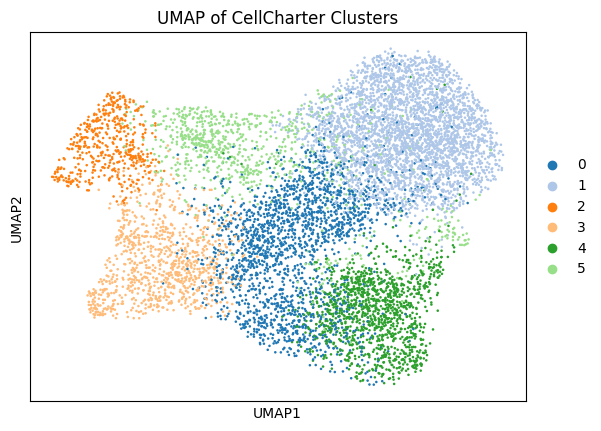

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

unique_labels = np.sort(adata.obs['cellcharter_labels'].dropna().unique())

from matplotlib.colors import ListedColormap
cmap = plt.get_cmap('tab20')
color_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}

sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cellcharter_labels", palette=color_dict, title="UMAP of CellCharter Clusters")
plt.show()


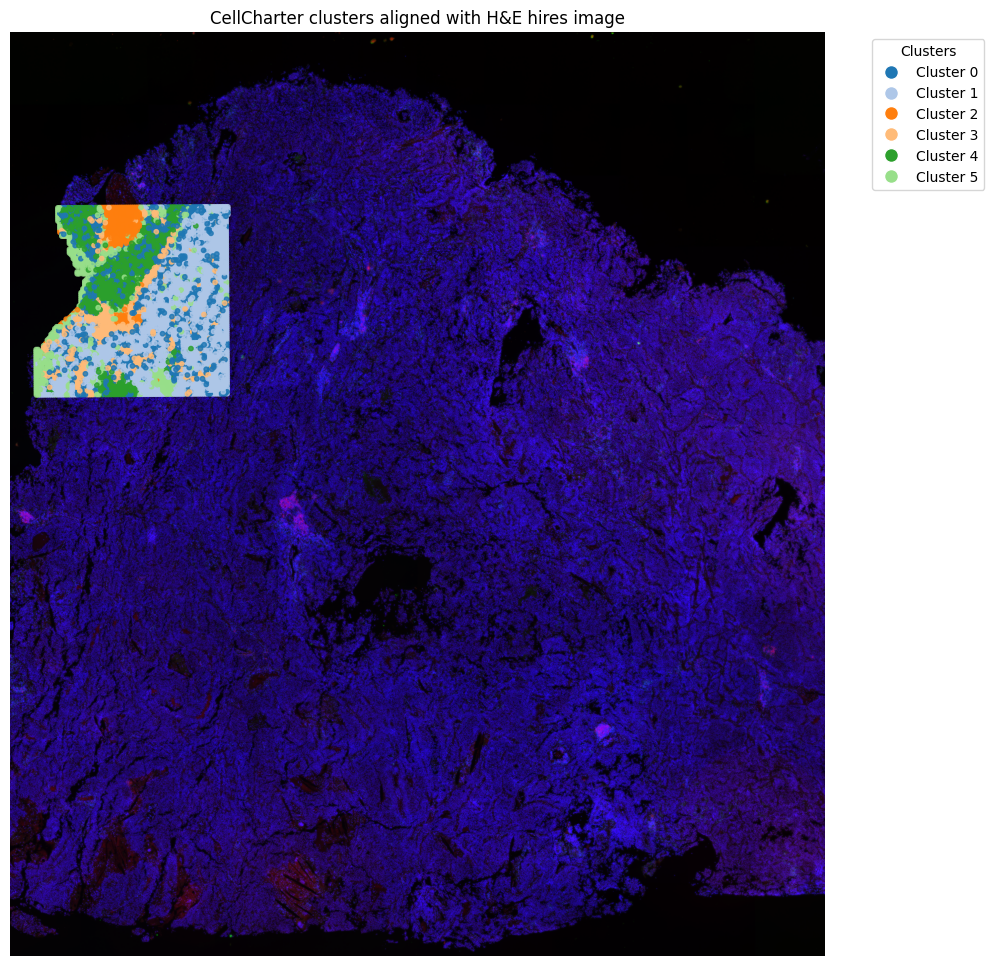

In [ ]:
import json
scalefactors_path = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/spatial/scalefactors_json.json"
with open(scalefactors_path, "r") as f:
    scalefactors = json.load(f)
scale = scalefactors["tissue_hires_scalef"]
adata.obs["x_hires"] = adata.obs["x"] * scale
adata.obs["y_hires"] = adata.obs["y"] * scale
he_image_path = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/spatial/tissue_hires_image.png"
he_image = cv2.imread(he_image_path)
he_image = cv2.cvtColor(he_image, cv2.COLOR_BGR2RGB)

colors = []
for label in adata.obs['cellcharter_labels']:
    if pd.isna(label):
        colors.append((0, 0, 0, 0))
    else:
        colors.append(color_dict.get(label, (0, 0, 0, 1)))

plt.figure(figsize=(12, 12))
plt.imshow(he_image)
scatter = plt.scatter(
    adata.obs['y_hires'],
    adata.obs['x_hires'],
    c=colors,
    s=10,
    alpha=0.8
)


legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label],
                              markersize=10, label=f'Cluster {label}') for label in unique_labels]
plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("CellCharter clusters aligned with H&E hires image")
plt.axis("off")
plt.show()

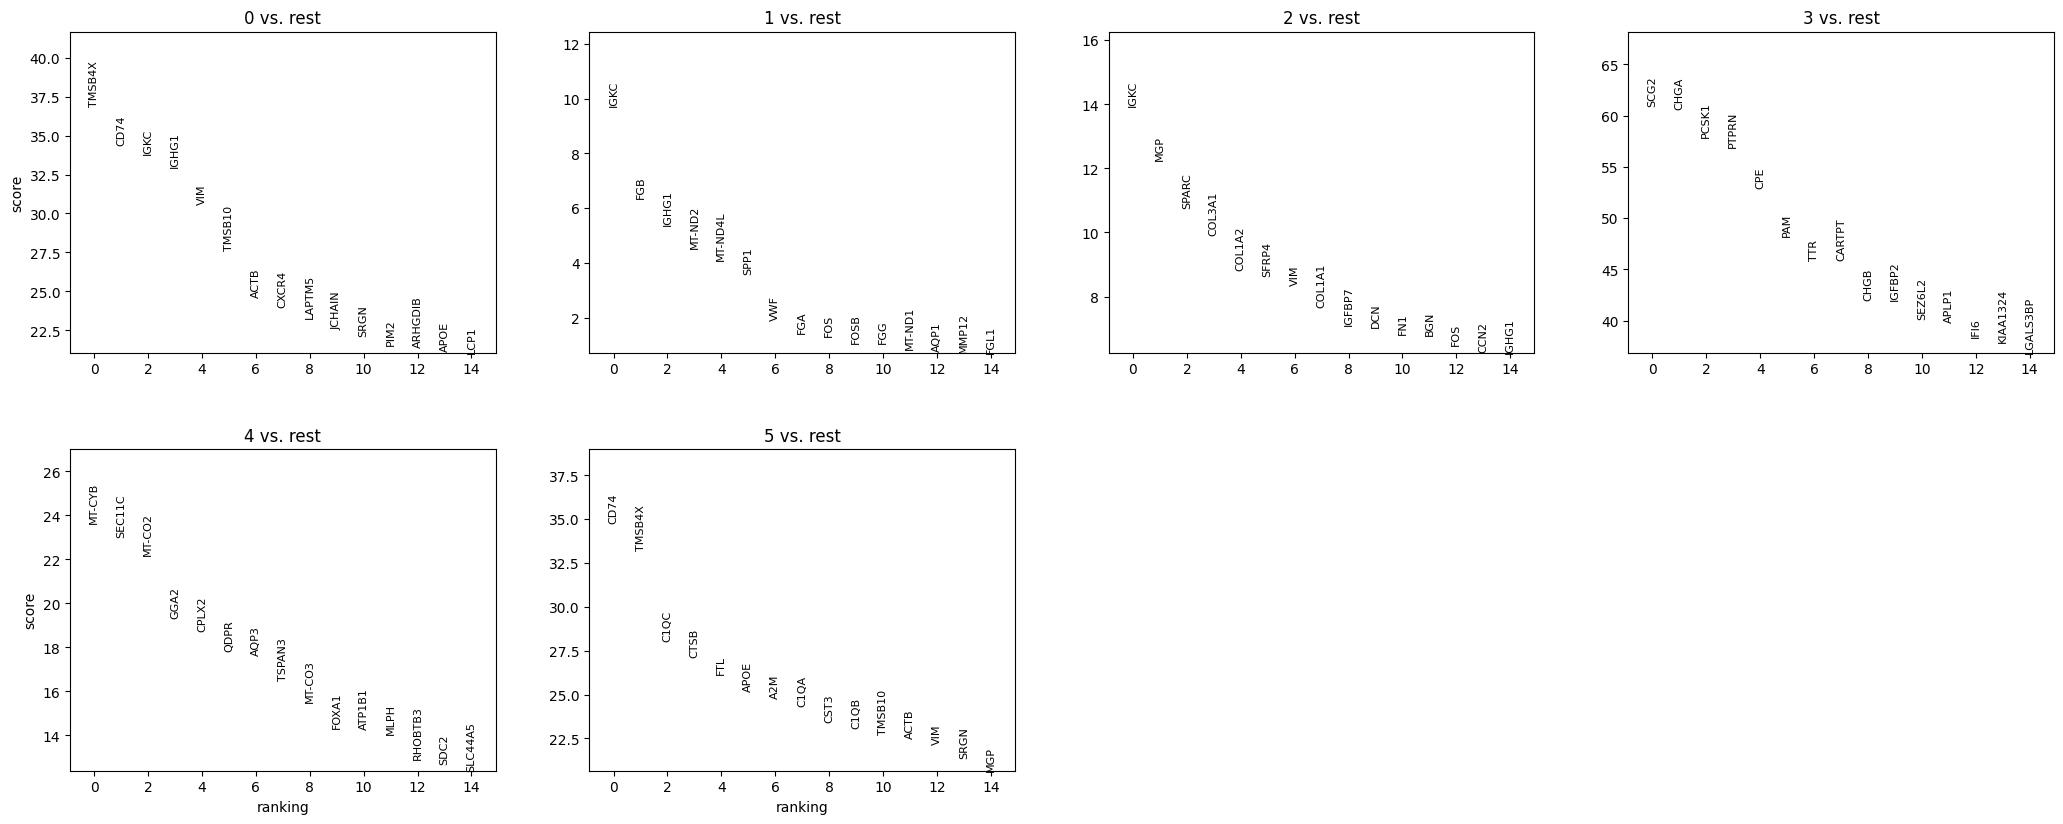

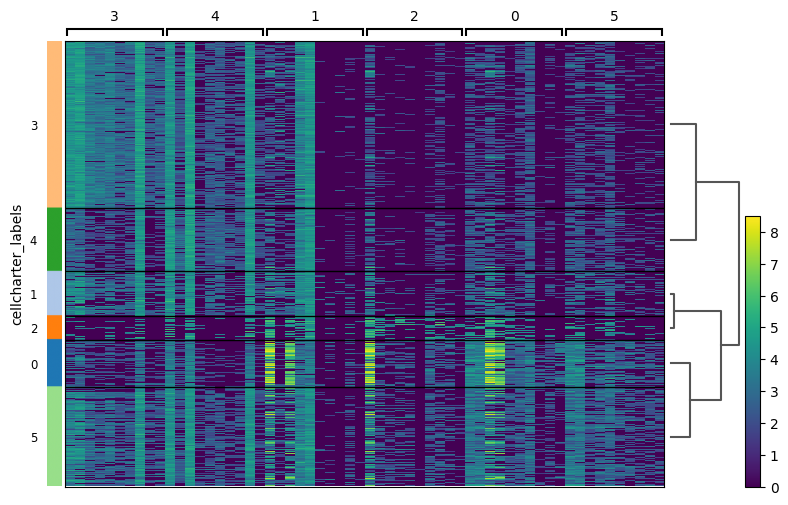

In [ ]:
adata.var_names_make_unique()

sc.tl.rank_genes_groups(
    adata,
    groupby="cellcharter_labels",
    method="wilcoxon",
    key_added="rank_genes"
)

sc.pl.rank_genes_groups(adata, n_genes=15, key="rank_genes", sharey=False)

sc.pl.rank_genes_groups_heatmap(
    adata,
    key="rank_genes",
    n_genes=10,
    groupby="cellcharter_labels",
    show=True
)

/tmp/ipython-input-1993537172.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_exp = expr.groupby(groupby).mean().T


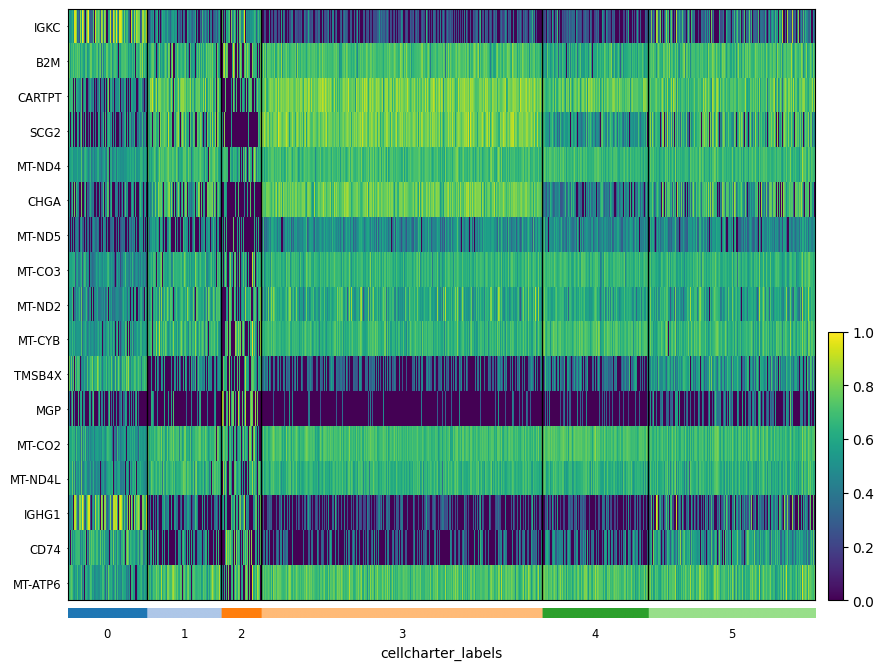

==== 所有 top genes（去重后） ====
['IGKC', 'B2M', 'CARTPT', 'SCG2', 'MT-ND4', 'CHGA', 'MT-ND5', 'MT-CO3', 'MT-ND2', 'MT-CYB', 'TMSB4X', 'MGP', 'MT-CO2', 'MT-ND4L', 'IGHG1', 'CD74', 'MT-ATP6']
总共 17 个基因

Cluster 0 Top 10 genes:
['IGKC', 'IGHG1', 'TMSB4X', 'B2M', 'MT-ND4', 'CD74', 'MT-CO2', 'MT-ATP6', 'MT-CYB', 'MT-ND4L']

Cluster 1 Top 10 genes:
['MT-ND4', 'MT-CO2', 'MT-ND4L', 'CARTPT', 'MT-CYB', 'MT-CO3', 'MT-ATP6', 'CHGA', 'MT-ND2', 'B2M']

Cluster 2 Top 10 genes:
['IGKC', 'MT-ND4', 'MT-CO2', 'MT-ND4L', 'MT-ATP6', 'MT-CYB', 'MT-CO3', 'IGHG1', 'MT-ND2', 'MGP']

Cluster 3 Top 10 genes:
['CARTPT', 'MT-ND4', 'CHGA', 'MT-CO2', 'MT-ND4L', 'MT-CO3', 'MT-ATP6', 'SCG2', 'MT-CYB', 'B2M']

Cluster 4 Top 10 genes:
['MT-CO2', 'MT-ND4', 'MT-CYB', 'MT-CO3', 'MT-ND4L', 'CARTPT', 'MT-ATP6', 'MT-ND2', 'B2M', 'MT-ND5']

Cluster 5 Top 10 genes:
['MT-ND4', 'MT-CO2', 'MT-ND4L', 'CARTPT', 'MT-CYB', 'MT-CO3', 'MT-ATP6', 'B2M', 'MT-ND2', 'CHGA']



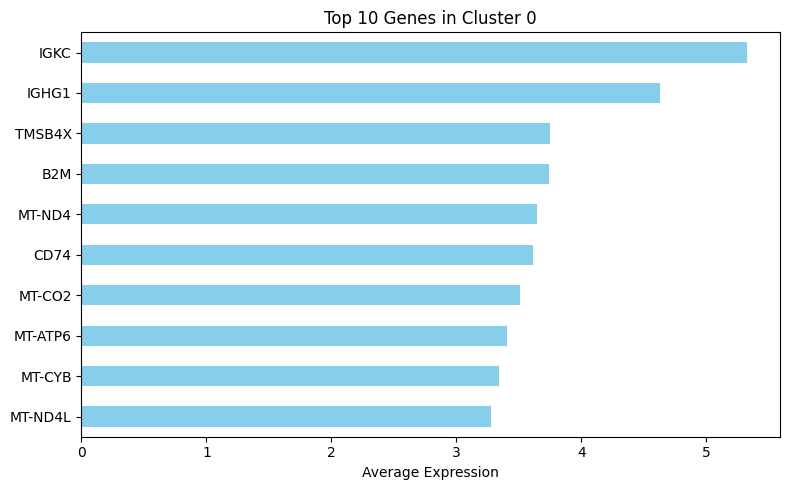

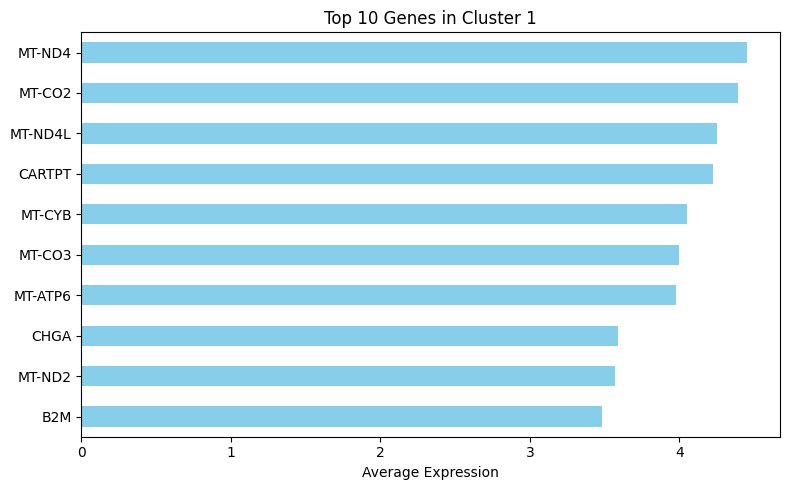

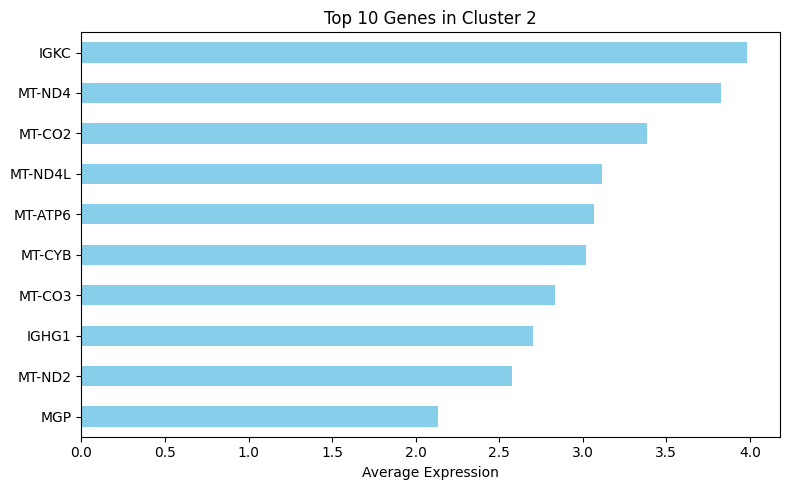

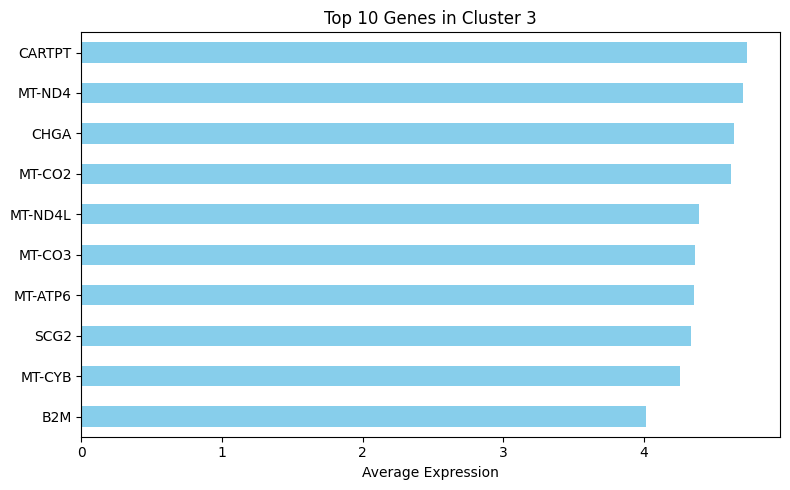

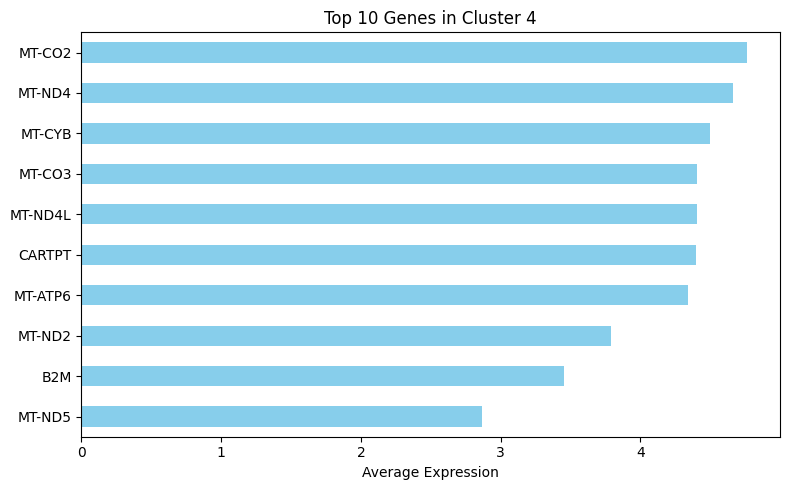

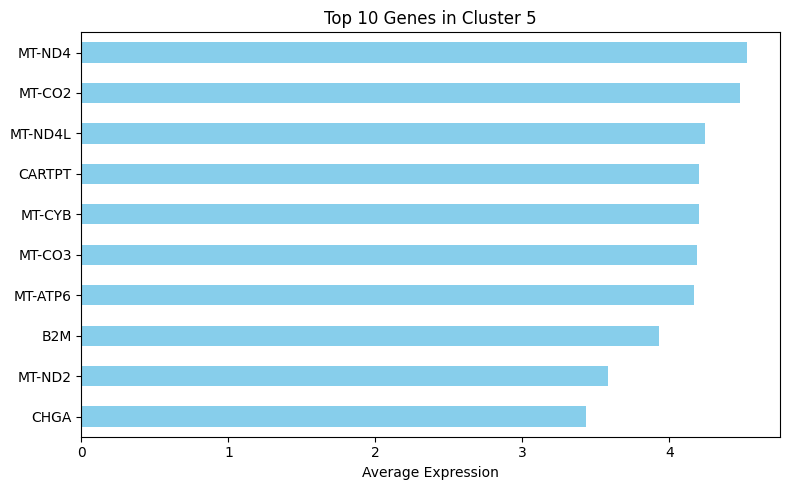

In [ ]:
import matplotlib.pyplot as plt
import os

adata.var_names_make_unique()

groupby = "cellcharter_labels"

expr = adata.to_df()
expr[groupby] = adata.obs[groupby].values

mean_exp = expr.groupby(groupby).mean().T

top_genes = {}
for cluster in mean_exp.columns:
    top_genes[cluster] = mean_exp[cluster].sort_values(ascending=False).head(10).index.tolist()

top_gene_list = list(set(sum(top_genes.values(), [])))

sc.pl.heatmap(
    adata,
    var_names=top_gene_list,
    groupby=groupby,
    cmap="viridis",
    standard_scale="var",
    swap_axes=True,
    figsize=(10,8),
    show=True
)

for cluster, genes in top_genes.items():

    cluster_mean = mean_exp[cluster].loc[genes]


    plt.figure(figsize=(8,5))
    cluster_mean.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel("Average Expression")
    plt.title(f"Top 10 Genes in Cluster {cluster}")
    plt.tight_layout()
print("==== 所有 top genes（去重后） ====")
print(top_gene_list)
print(f"总共 {len(top_gene_list)} 个基因\n")

for cluster, genes in top_genes.items():
    print(f"Cluster {cluster} Top 10 genes:")
    print(genes)
    print()


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

expr_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
expr_df = pd.DataFrame(expr_matrix, index=adata.obs_names, columns=adata.var_names)

expr_df.T.to_csv("/content/expression_matrix_for_SingleR.csv")
print("导出完成，路径：/content/expression_matrix_for_SingleR.csv")


导出完成，路径：/content/expression_matrix_for_SingleR.csv


0 missing annotations
s_016um_00010_00367-1    Fibroblasts
s_016um_00000_00401-1    Gametocytes
s_016um_00010_00356-1        T_cells
s_016um_00022_00385-1         B_cell
s_016um_00030_00363-1     Macrophage
Name: SingleR_annotated, dtype: object


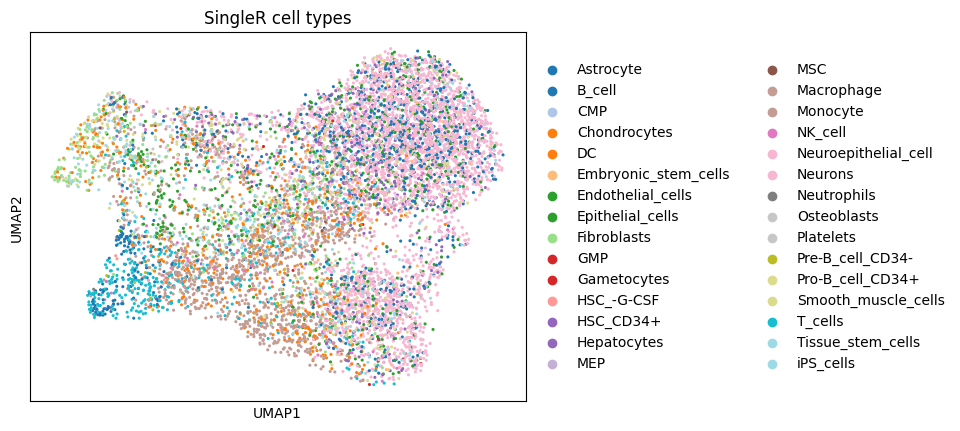

In [ ]:
import pandas as pd
import scanpy as sc

singleR_file = "/content/SingleR_HPCA_results.csv"
singleR_labels = pd.read_csv(singleR_file)

cluster_dict = pd.Series(
    singleR_labels.iloc[:, 1].values,
    index=singleR_labels.iloc[:, 0].astype(str)
).to_dict()

adata.obs["SingleR_annotated"] = adata.obs_names.astype(str).map(cluster_dict)

missing = adata.obs["SingleR_annotated"].isna().sum()
print(f"{missing} missing annotations")
print(adata.obs["SingleR_annotated"].head())

sc.pl.umap(
    adata,
    color="SingleR_annotated",
    title="SingleR cell types",
    palette="tab20",
    size=20
)

/tmp/ipython-input-2391128074.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(cluster_key)["SingleR_celltype"]


✅ Cluster-level annotations saved to: /content/SingleR_cluster_annotations.csv
  cellcharter_labels SingleR_cluster_annotation
0                  0                 Macrophage
1                  1                    Neurons
2                  2                Fibroblasts
3                  3                    T_cells
4                  4                    Neurons


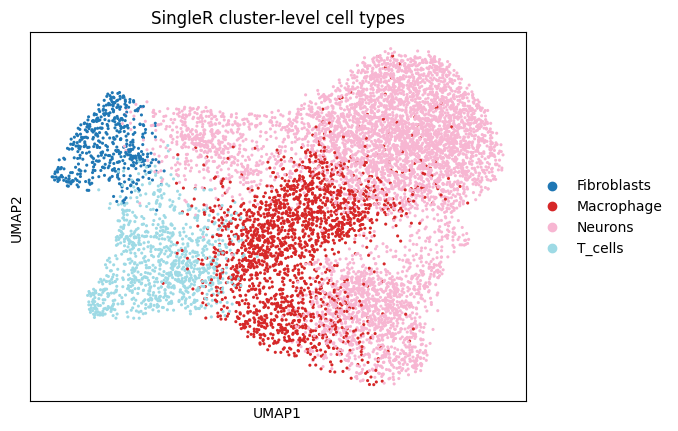

In [ ]:
import pandas as pd
import scanpy as sc

singleR_file = "/content/SingleR_HPCA_results.csv"
singleR_labels = pd.read_csv(singleR_file)

cluster_dict = pd.Series(
    singleR_labels.iloc[:, 1].values,
    index=singleR_labels.iloc[:, 0].astype(str)
).to_dict()
adata.obs["SingleR_celltype"] = adata.obs_names.astype(str).map(cluster_dict)

cluster_key = "cellcharter_labels"


cluster_annotations = (
    adata.obs.groupby(cluster_key)["SingleR_celltype"]
    .agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
)


adata.obs["SingleR_cluster_annotated"] = adata.obs[cluster_key].map(cluster_annotations)


cluster_annotations_df = cluster_annotations.reset_index()
cluster_annotations_df.columns = [cluster_key, "SingleR_cluster_annotation"]

out_file = "/content/SingleR_cluster_annotations.csv"
cluster_annotations_df.to_csv(out_file, index=False)

print("Cluster-level annotations saved to:", out_file)
print(cluster_annotations_df.head())


sc.pl.umap(
    adata,
    color="SingleR_cluster_annotated",
    title="SingleR cluster-level cell types",
    palette="tab20",
    size=20
)
